In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [40]:
N_ep = 10 # Number of episodes
prop_test = 0.2 # Proportion of test set
shuffle = False # Shuffle data every episode
episode_rec = int(N_ep/10)

[[tensor([[  0.0000,   0.0000,   0.0000,  30.5567,   2.3746,   2.4849]]), tensor([[  0.0000,   0.0000,   0.0000,  34.7300,   2.4314,   2.5649]]), tensor([[  0.0000,   0.0000,   0.0000,  38.4100,   2.1338,   2.6391]]), tensor([[  0.0000,   0.0000,   0.0000,  43.7833,   2.5151,   2.7081]]), tensor([[  0.0000,   0.0000,   0.0000,  43.0667,   2.3010,   2.7726]]), tensor([[  0.0000,   0.0000,   0.0000,  54.7033,   2.5853,   2.8332]]), tensor([[  0.0000,   0.0000,   0.0000,  49.2867,   2.8127,   2.8904]]), tensor([[  0.0000,   0.0000,   0.0000,  56.7433,   2.3813,   2.9444]]), tensor([[  0.2467,   0.7692,   0.9463,  68.8167,   2.5117,   2.9957]]), tensor([[  0.2667,   0.7625,   0.9597,  69.0700,   2.7659,   3.0445]])], tensor(1.00000e-02 *
       4.5130, device='cuda:0'), tensor(9.2178, device='cuda:0'), tensor(9.1726, device='cuda:0'), tensor(9.1362, device='cuda:0')]
tensor([[     1.0000,      1.0000,      1.0000,  ...,     29.5033,
              0.7391,      2.3979],
        [     0.0000,

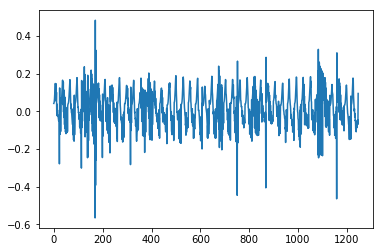

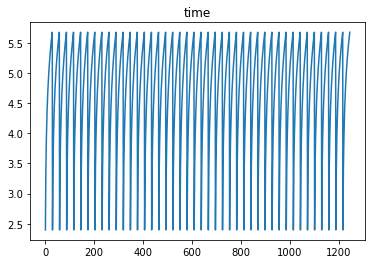

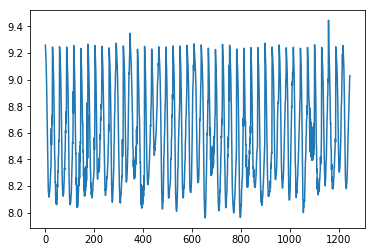

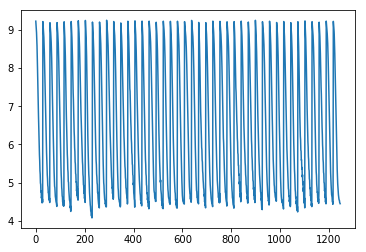

In [42]:
# Load data
f = open('dqn_models2/replay_memory_42','rb')
# f = open('replay_memory_0_500','rb')
dataset = pickle.load(f)

print (dataset[1])

# Data size
num_data = len(dataset)
# Features


X = torch.cat([torch.cat(x[0], 1) for x in dataset]).float()
print (X)
# Labels
y = torch.from_numpy(np.array([x[1] for x in dataset])).float()
# print (torch.cat(dataset[0][0], 1))
input_dim = 6

# X = X[:150, :]
# y = y[:150]
# Initial shuffle
if shuffle:
    permutation = torch.randperm(num_data)
#     X = X[permutation][:150, :]
#     y = y[permutation]
#     y = y[:150]
    X = X[permutation]
    y = y[permutation]

plt.plot(y)
plt.show()

time = [x[-1] for x in X]
plt.plot(time)
plt.title("time")
plt.show()



val_loss = torch.from_numpy(np.array([x[2] for x in dataset])).float()
plt.plot(val_loss)
plt.show()

train_loss= torch.from_numpy(np.array([x[4] for x in dataset])).float()
plt.plot(train_loss)
plt.show()    
    
    
num_train = int(num_data*(1-prop_test))
# num_train = 100
X_train = X[:num_train]
y_train = y[:num_train]
X_test = X[num_train:]
y_test = y[num_train:]

# Normalize
y_train = y_train/abs(y_train).max()
# print (y_test)
y_test = y_test/abs(y_test).max()

In [34]:
# Network
class net(nn.Module):
    def __init__(self, input_dim=6, output_dim=1, hidden_size=6, hidden_dropout_prob=0):
        super(net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size) # input layer -> hidden layer
        self.fc2 = nn.Linear(hidden_size, output_dim) # hidden layer -> output layer
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = net(input_dim=input_dim)
print (model)

net(
  (fc1): Linear(in_features=6, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)


In [35]:
sample_num=10
# print(model(X[sample_num]))
# print(y[sample_num])
# print(model(X[sample_num])-y[sample_num])
# print (X[0])
# print (len(torch.split(X[0], 6)))

In [36]:
optimizer = optim.SGD(model.parameters(),lr=0.001)

training_loss = []
test_loss = []



# Training
for i_ep in range(N_ep):
    
    if shuffle:
        permutation = torch.randperm(num_train)
        X_train = X_train[permutation]
        y_train = y_train[permutation]
        
#     for i_data in range(num_train):
#         features = X_train[i_data]
#         y_data = y_train[i_data]
#         #features = X
#         #y_data = y.view(-1,1)
        
#         y_pred = model(features)
        
#         #loss = F.smooth_l1_loss(y_pred,y_data)
#         loss = torch.mean((y_pred - y_data)**2)
        
#         # Optimize the model
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
        for i in range(num_train):
            state_action_values_sum = 0
            state_list = torch.split(X_train[i], 6)
            for state in state_list:
#                 print ("#", state)
                state_action_value = model(state)     
                state_action_values_sum += state_action_value
                
#             state = X_train[i]
            reward = y_train[i]

            expected_state_action_values = torch.FloatTensor([reward])
            loss = F.smooth_l1_loss(state_action_values_sum.view(1), expected_state_action_values) # Compute Huber loss

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   


        
#         state_action_values_sum = 0
#         for i in range(num_train):
#             if i % 10 != 0:
#                 state = X_train[i]
#                 reward = y_train[i]
#                 state_action_value = model(state)
#                 state_action_values_sum += state_action_value

#                 if i == 9 and num_train == 10: # First turn
#                     expected_state_action_values = torch.FloatTensor([reward])
#                     loss = F.smooth_l1_loss(state_action_values_sum.view(1), expected_state_action_values) # Compute Huber loss

#                     # Optimize the model
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#             elif i != 0 and i % 10 == 0:
#                 expected_state_action_values = torch.FloatTensor([reward])
#                 loss = F.smooth_l1_loss(state_action_values_sum.view(1), expected_state_action_values) # Compute Huber loss

#                 # Optimize the model
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 state = X_train[i]
#                 reward = y_train[i]
#                 state_action_value = model(state)
#                 state_action_values_sum = state_action_value
            
        
        
    y_train_pred = []
    
    # Compute training & test losses and record
    for xx in X_train:
        y_t_sum = 0
        xx_list = torch.split(xx, 6)
#         print (xx_list)
        for xx_loop in xx_list:
            y_t_pred = model(xx_loop)
            y_t_sum += y_t_pred
        y_train_pred.append(y_t_sum)
    
    y_train_pred = torch.tensor(y_train_pred)
    print (y_train_pred)
    
#     y_train_pred = model(X_train)
    
    y_test_pred = []
    for xx in X_test:
        y_t_sum = 0
        xx_list = torch.split(xx, 6)
#         print (xx_list)
        for xx_loop in xx_list:
            y_t_pred = model(xx_loop)
            y_t_sum += y_t_pred
        y_test_pred.append(y_t_sum)
    
    y_test_pred = torch.tensor(y_test_pred)
#     print (y_test_pred)

    
    
    
    loss_train = torch.mean((y_train-y_train_pred)**2)
#     y_test_pred = model(X_test)
    loss_test = torch.mean((y_test-y_test_pred)**2)
    training_loss.append(loss_train)
    test_loss.append(loss_test)
        
    if i_ep != 0 and (i_ep % episode_rec == 0):
        print(i_ep)

tensor([ 0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0221,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
         0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,  0.0285,
      

tensor([ 0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0269,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0291,  0.0293,  0.0293,
         0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,  0.0293,
      

1
tensor([-0.0133, -0.0798, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0169, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0135, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0133, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
        -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132, -0.0132,
    

2
tensor([ 0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
         0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,  0.0679,
    

3
tensor([ 0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0872,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
         0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,  0.0873,
    

4
tensor([ 0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0691,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0518,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,  0.0702,
         0.0702,  0.0702,  0.0105,  0.0702,  0.0702,  0.0702,  0.0702,
    

tensor([ 0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0630,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,
         0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.0805,  0.0809,
      

6
tensor([ 0.1038,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
         0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,  0.1208,
    

7
tensor([-0.0092, -0.0092, -0.0092, -0.0092, -0.0250, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
        -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092, -0.0092,
    

8
tensor([ 0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1145,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.0696,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
         0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,  0.1293,
    

9


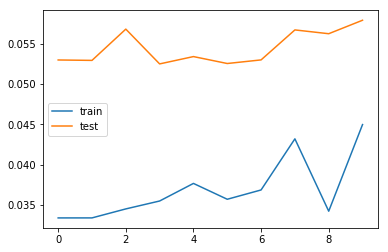

In [37]:
plt.plot(training_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
#plt.savefig('train_loss_curve.png')
plt.show()

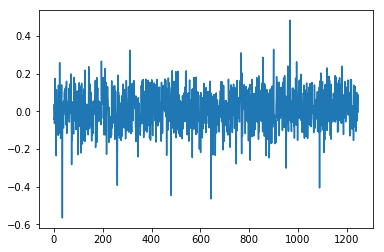

tensor(17.5309)


In [38]:
plt.plot(y)
plt.show()
print (sum(y))

In [39]:
ordered = []

X_orig = torch.cat([x[0] for x in dataset]).float()

t_list = X_train[:,-1].numpy()
t_list = t_list[:120]

l_list =  X_train[:,-2].numpy()
print(y[np.argsort(y)])
# t_list[np.argsort(t_list)]
y_sort = y_train[np.argsort(t_list)]

plt.plot(y_sort)
plt.show()


y_model = model(X_train).detach().numpy()
y_model = y_model[np.argsort(t_list)]
plt.plot(y_model)
plt.show()

# plt.plot(y_train)
# plt.show()

TypeError: expected Variable as element 0 in argument 0, but got list

In [ ]:

plt.plot(y_train)
plt.show()